In [38]:
import tensorflow as tf
import numpy as np

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Train:", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (50000, 32, 32, 3) (50000,)
Test:  (10000, 32, 32, 3) (10000,)


In [46]:
import tensorflow as tf

def triplet_loss(margin=1.0):
    """
    Custom triplet loss function using margin-based formulation:
       L = max(0, d(anchor, positive) - d(anchor, negative) + margin),
    where d(x,y) is the squared distance between x and y.
    """
    def _triplet_loss(y_true, y_pred):
        # y_pred is expected to be of shape: (batch_size, 3, embedding_dim)
        anchor = y_pred[:, 0]
        positive = y_pred[:, 1]
        negative = y_pred[:, 2]
        
        # Calculate L2 distances
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        
        # Compute the triplet loss
        loss = tf.nn.relu(pos_dist - neg_dist + margin)
        
        return tf.reduce_mean(loss)
    
    return _triplet_loss



Label distribution in training set:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


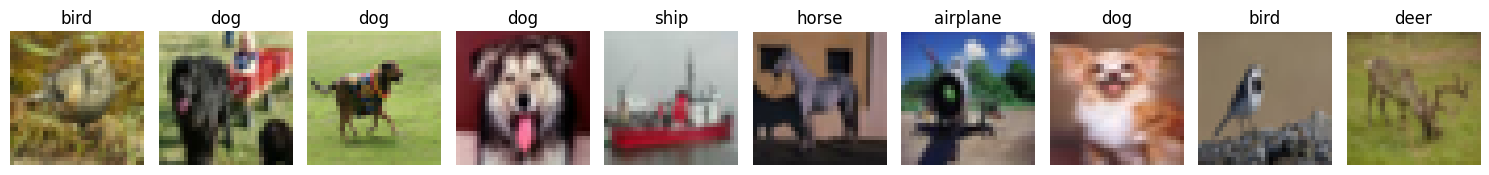

In [48]:
import matplotlib.pyplot as plt

# Define the class names for CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Let’s look at the distribution of labels in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("\nLabel distribution in training set:")
for label, count in zip(unique, counts):
    print(f"{class_names[label]}: {count}")

# Function to plot random images from the dataset
def plot_random_images(images, labels, class_names, num_images=10):
    """
    Plots a specified number of random images from the dataset,
    labeled by their CIFAR-10 class names.
    """
    # Choose random indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    # Define the size of the figure based on how many images we show
    plt.figure(figsize=(15, 2))

    for i, idx in enumerate(random_indices):
        # Subplot arrangement: 1 row, 'num_images' columns
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot some random images from the training set
plot_random_images(x_train, y_train, class_names, num_images=10)

In [47]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    # optimizer = tf.keras.optimizers.Adam(0.001),
    # loss='sparse_categorical_crossentropy',
    loss=triplet_loss(margin=1.0),
    # loss = tfa.losses.TripletHardLoss,
    metrics=['accuracy']
)

model.summary()

history_single_filter = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=64,
    batch_size=10,
    verbose=True
)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

/Users/mateusz/.venv_3_12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_109 (Conv2D)             │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,714 (690.29 KB)

 Trainable params: 176,714 (690.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64


ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for '{{node compile_loss/_triplet_loss/Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](compile_loss/_triplet_loss/Square, compile_loss/_triplet_loss/Sum/reduction_indices)' with input shapes: [10], [] and with computed input tensors: input[1] = <1>.